# Install Offline MMDetection

In [1]:
!pip install -qqq /kaggle/input/mmdetv3-env/archive/addict-2.4.0-py3-none-any.whl
!pip install -qqq /kaggle/input/mmdetv3-env/archive/mmengine-0.7.4-py3-none-any.whl
!pip install -qqq /kaggle/input/mmdetv3-env/archive/mmcv-2.0.0-cp310-cp310-linux_x86_64.whl
!pip install -qqq /kaggle/input/mmdetv3-env/archive/terminaltables-3.1.10-py2.py3-none-any.whl
# !pip install -qqq /kaggle/input/mmdetv3-env/archive/openmim-0.3.9-py2.py3-none-any.whl
!pip install -qqq /kaggle/input/pycocotools-206/wheels/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
# !pip install -qqq /kaggle/input/mmdet3-wheels-ando/mmdet-3.0.0-py3-none-any.whl
!pip install -qqq /kaggle/input/weighted-boxes-fusion/ensemble_boxes-1.0.9-py3-none-any.whl

!pip install -qqq /kaggle/input/mmdetection-3-1-evn/src/mmdet-3.1.0-py3-none-any.whl

In [2]:
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools.coco import COCO
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import wandb
from PIL import Image
import gc

from glob import glob
import matplotlib.pyplot as plt


import base64
import numpy as np
from pycocotools import _mask as coco_mask
from typing import Text, Dict, Tuple
import zlib

import mmdet, mmcv, mmengine
from mmengine.config import Config
from mmengine.runner import Runner
from mmdet.utils import register_all_modules
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer


print(mmdet.__version__)
print(mmcv.__version__)
print(mmengine.__version__)

3.1.0
2.0.0
0.7.4


In [3]:
def encode_binary_mask(mask: np.ndarray) -> Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [4]:
def dilate_predict_mask(out_mask):
    for i in range(len(out_mask)):
        kernel = np.ones(shape=(3, 3), dtype=np.uint8)
        out_mask[i] = cv2.dilate(out_mask[i], kernel, 3)
    return out_mask

from skimage.morphology import binary_dilation

In [5]:
%mkdir work_dir_test

In [6]:
path_list = ["/kaggle/input/hubmap-hacking-the-human-vasculature/test/"+i for i in os.listdir("/kaggle/input/hubmap-hacking-the-human-vasculature/test/")]
path_list

['/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif']

In [7]:
# cfg = Config.fromfile("/kaggle/working/work_dir_test/custom_config.py")
cfg = Config.fromfile("/kaggle/input/hubmap-mmdet-fold-1/custom_config.py")
cfg.work_dir = "/kaggle/working/work_dir_test"
vis_backends = [dict(type='LocalVisBackend')]
cfg.visualizer = dict(type='DetLocalVisualizer', vis_backends=vis_backends, name='visualizer')
runner = Runner.from_cfg(cfg)

07/10 04:50:32 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 1870050053
    GPU 0: Tesla P100-PCIE-16GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 2.0.0
    PyTorch compiling details: PyTorch built with:
  - GCC 11.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-genc

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

07/10 04:50:53 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
07/10 04:50:53 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
(LOWEST      ) EarlyStoppingHook                  
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_i

Loads checkpoint by local backend from path: /kaggle/input/hubmap-mmdet-fold-1/best_coco_segm_mAP_epoch_9.pth


/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:757: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:828: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(


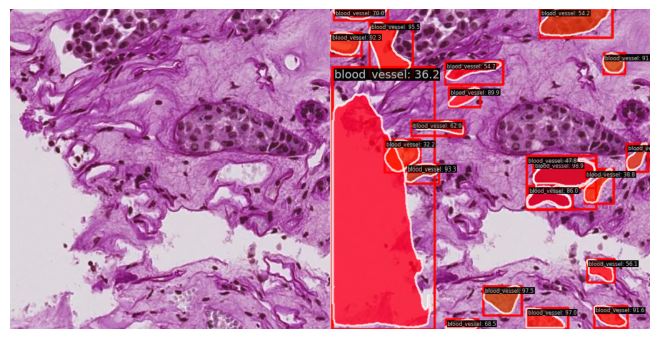

In [8]:
img = mmcv.imread("/kaggle/input/hubmap-hacking-the-human-vasculature/test/72e40acccadf.tif")
checkpoint_file = "/kaggle/input/hubmap-mmdet-fold-1/best_coco_segm_mAP_epoch_9.pth"

model = init_detector(cfg, checkpoint=checkpoint_file, device="cuda:0")
new_result = inference_detector(model, imgs=path_list)


visualizer_now = Visualizer.get_current_instance()

visualizer_now.dataset_meta = model.dataset_meta
visualizer_now.set_image(img)
visualizer_now.add_datasample(
    'new_result',
    img,
    data_sample=new_result[0],
    draw_gt=True,
    draw_pred=True,
    wait_time=0,
)
visualizer_now.show()

In [9]:
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import dilation, erosion

/tmp/ipykernel_23/2193415764.py:1: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_fill_holes


In [10]:
ids = []
heights = []
widths = []
prediction_string = []
new_mask = []

for res in new_result:
    pr_i = res.pred_instances
    id = res.img_path.split("/")[-1][:-4]
    shape = new_result[0].img_shape
    height = shape[0]
    width = shape[1]

    scores = pr_i.scores.cpu().numpy()
    bboxes = pr_i.bboxes.cpu().numpy()
    masks = pr_i.masks.cpu().numpy()
    labels = pr_i.labels.cpu().numpy()

    current_size = (height, width)
    
    target_size = (512, 512)
    
    height,width = target_size
    
    print("masks:", masks.shape)
    
    pred_strings = []

    for label, score, mask in zip(labels,scores, masks):
        pred_strings_txt = ""
#         mask = binary_dilation(mask)

        mask = binary_fill_holes(mask)
        mask = erosion(dilation(mask))
        new_mask.append(mask)
        if label==0:
            pred_strings_txt += f"0 {score} {encode_binary_mask(mask).decode('utf-8')}"
            print("pred_strings_txt:", pred_strings_txt)
        else:
            pred_strings_txt += f" 0 {score} {encode_binary_mask(mask).decode('utf-8')}"
            
        pred_strings.append(pred_strings_txt)
    ids.append(id)
    heights.append(height)
    widths.append(width)
    prediction_string.append(" ".join(pred_strings))

sub = pd.DataFrame({"id": ids, "height": heights, "width": widths, "prediction_string": prediction_string})
sub = sub.set_index("id")
sub.to_csv("submission.csv")

/tmp/ipykernel_23/1612669892.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask.dtype != np.bool:


masks: (65, 512, 512)
pred_strings_txt: 0 0.9887191653251648 eNqLjwgyNU63t/I28jP0N/SHkIYGBv4oNIxtYAAjETQKMPSHyYBZqDRWHUhmQZT6GxgiG4WwGGKEn7EfSATkUCD2NfEz8jPyNfYz9gmOiDEEAHeDLYQ=
pred_strings_txt: 0 0.9752854704856873 eNqLyssyNsuwN/Ex9jX2M/Iz9DfyN4BhA0N/BATzDAzgNEQEiv2AIiAxCAaTIASVNPI19jf0MQFZ4Gvia+Rv5GvkY+YekRRuDACbcB5S
pred_strings_txt: 0 0.9702428579330444 eNoLyM8xyTcIsDfyN8AFDP0x+RAxBImJQRAii86C0Ib+Rn6Gfsa+4QEhRgCdEB2r
pred_strings_txt: 0 0.9549749493598938 eNo9jcEOgjAQRH9pijReiib0SOmqEKmpkiDGSAzl/29uS3A3u2/eadrzgkN/3FfS5GZXx020a46WG1mlbIUVIECQ4B9n4996O5YDHsWdPuUTrvAU2Bv2ix5wYjZ6RFCeWv3CrBx1+o2v6ujGnNSVvJ4QCsoI69mM22Lxdqk/5loaNy/yB2BHM6s=
pred_strings_txt: 0 0.9389410018920898 eNpLDo81t062N/Ex8TXyN/A39Dc0MIBgEPQzNABjfwMggJBA4G9g5GvsawzUYuxn5GfkY+IXGWkEAJaIEaA=
pred_strings_txt: 0 0.9330724477767944 eNqLicgxNM6wt/Y09AdBIz8wbWAAJA1ACMgyMARzDGCkgQFIECwFZiMDoBI40w+kwsgfzAIabOwblBFpCgDLiRmo
pred_strings_txt: 0 0.9233148097991943 eNqLNUwziLQ38jPyN/AHYUMgaQiiDUAAyAJjGBsOEBwgy9AfqNzQzxDE9jf